In [1]:
using Revise

In [2]:
# Add PATH
push!(LOAD_PATH, joinpath(@__DIR__, "..", "src"))

#using PyPlot
using Plots
using BenchmarkTools
using DifferentialEquations

using LSM.PhysCon
using LSM.WaterVaporMod
#using LSM.LeafPhotosynthesisMod
using LSM.LeafEnergyWaterBalanceMod

output_dir = joinpath(@__DIR__,"..","output")
mkpath(output_dir)

"/Users/gentine/Dropbox/Collaborations_Projects/Optimal_Stomata/LSM-SPAM/test/../output"

In [3]:

# function lorenz!(du,u,p,t)
#  du[1] = 10.0*(u[2]-u[1]);
#  du[2] = u[1]*(28.0-u[3]) - u[2];
#  du[3] = u[1]*u[2] - (8/3)*u[3];
# end
# u0 = [1.0;0.0;0.0];
# tspan = (0.0,100.0);
# prob = ODEProblem(lorenz!,u0,tspan);
# sol = solve(prob);

# plot(sol,vars=(1,2,3))

# Create a leaf structure
l = leaf_params{Float32}();
# Create a Flux structure
f = fluxes{Float32}();
# Create a meteo structure
met = meteo{Float32}();

#met = meteo();

# initialize some reasonable values
f.Je   = 100; f.gbc  = 100; f.gbv  = 100; f.ceair= 1500; f.eair = 1500; f.APAR = 500; f.H=0;f.LE=0; # leaf should not have eair
l.Kn = 2.44; l.α=0.2; l.ε=0.98; l.LMA=100e-3; l.RWC=80/100;l.psi_l=-1e6;l.psi_l50 = -2e6;l.ck=3;met.zscreen = 2.0;
l.height   = 1.0; met.zscreen  = 2.0;
met.stab_type_stable = 2;

In [4]:
# A diurnal cycle for radiation and Tair
Deltat  = 60.0;
Samp    = 500.0; # W/m2 amplitude
DeltaSamp = 100.0;
Tmean   = 273.15+20;
DeltaT  = 3.0;
t       = range(0, stop=24*3600, step=Deltat); # diurnal cycle in seconds
#print(t)
Sdown_t = Samp*ones(size(t));
Tair_t  = Tmean*ones(size(t));
zeros_t = zeros(size(t));
for i = 1:length(Sdown_t)
    if(t[i]>3*3600)
         Sdown_t[i] = Samp+DeltaSamp;
    end
end
#print(typeof(phase[1]));
#print(typeof(Sdown_t[1]));
#print(Sdown_t);
#clf();
#fig = figure("Diurnal cycle", figsize=(10,5));
# plot(t/3600,Sdown_t)
#plot!(t/3600,10*(Tair_t-273.15*ones(size(Tair_t))))
#    title = "Shortwave Incoming radiation (W/m^2)");#,
#    xlabel = "Hours",
#    ylabel = "S_{down} (W/m^2)")
#plot(t/3600,Tair_t-273.15*ones(size(Tair_t)),
#    title = "Temperature (C)",
#    xlabel = "Hours",
#    ylabel = "Temperature (C)")


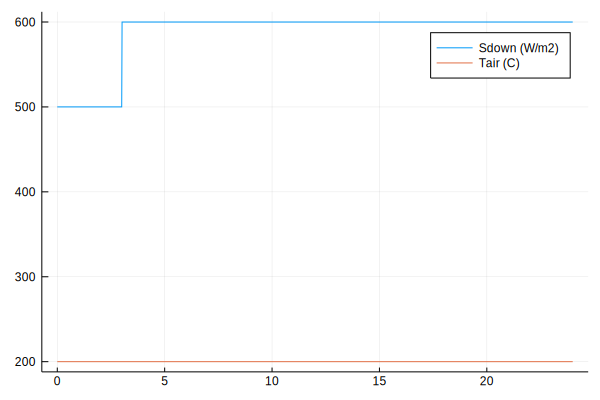

In [5]:
plot(t/3600,Sdown_t,label="Sdown (W/m2)")

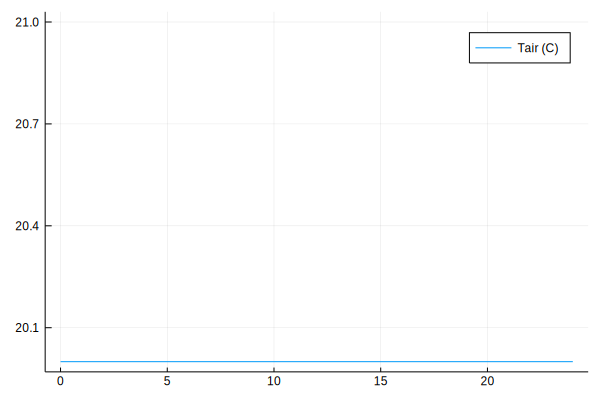

In [22]:
plot(t/3600,Tair_t-273.15*ones(size(Tair_t)),label="Tair (C)")

In [6]:
psi_s      = -0.3e6 ; # soil water potential (Pa)
U          =  1.0;
RH         =  65/100;
eps_air    =  0.75;
tspan      =  (0.0,Deltat);
N          =  length(Sdown_t);
mutable struct parameters_ode
    l::leaf_params;
    met::meteo;
    f::fluxes;
    psi_s;
end

In [41]:
# small time stepping
dt     = 0.01*60; # in s
T_t    = zeros(size(Sdown_t));
psil_t = zeros(size(Sdown_t));
Rn_t   = zeros(size(Sdown_t));
H_t    = zeros(size(Sdown_t));
LE_t   = zeros(size(Sdown_t));

function f_ode!(du,u,p,t) # p are parameters
    du .= LeafEnergyWaterBalance(u[1], u[2], p.met, p.l, p.f, p.psi_s);
    #println("du_inside = $(du), u_inside = $(u)")
end

let
    # initial conditions
    met.T_air  = Tair_t[1];
    l.T     = met.T_air;
    l.psi_l = psi_s;
    println("Tair1=",met.T_air," Tleaf1=",l.T," psi_leaf1=",l.psi_l)
        
    for i=1:N
        met.S_down = Sdown_t[i];
        met.L_down = eps_air*physcon.σ*(Tair_t[i])^4;
        met.T_air  = Tair_t[i];
        met.e_air  = RH*SatVap(Tair_t[i])[1];
        met.PAR    = 45/100*physcon.Wtoμmole_s*Sdown_t[i];
        f.APAR     = met.PAR;
        met.U      = U;
        met.Ca     = 400.0; #ppm
        f.APAR     = met.PAR;
        #println("Tair=",met.T_air," Tleaf=",l.T," psi_leaf=",l.psi_l)
        for j=1:trunc(Deltat/dt)
            u    = [l.T;l.psi_l];
            p    = parameters_ode(l,met,f,psi_s);
            #(p.met, p.l,  p.psi_s, p.U)    = [l;met;psi_s;U];
            #prob = ODEProblem(f_ode!,u0,tspan,p);
            #du   = zeros(size(u));
            #f_ode!(du,u,p,t,dummy);
            #println("du_outside = $(du), u_outside = $(u)")
            # Rn_t[i] = dummy[3]; H_t[i] = dummy[4]; LE_t[i] = dummy[5];
            #du   = zeros(size(u));
            #f_ode!(du,u,p,t);
            #(l.T,l.psi_l) = du*dt+u;
            
            u0   = [l.T;l.psi_l];
            prob = ODEProblem(f_ode!,u0,tspan,p);
            sol  = solve(prob);            
            (l.T,l.psi_l) = sol[1:2,end];
            
            
            Rn_t[i]   = p.f.Rn; H_t[i] = p.f.H; LE_t[i] = p.f.LE;
            
            #T_old   = l.T;
            #(l.T,l.psi_l) = du*dt+u;
            T_t[i]    = l.T ; #  = T_old; 
            psil_t[i] = l.psi_l;
            
            if(abs(H_t[i])>500)
                println("index ($i) ($j)")
            end
            
            
#             (dumb,l.psi_l) = du*dt+u;
#             T_t[i]  = dumb ; #  = T_old; 

            
        end
    end

#     l.T        = Tair_t[1]; # initialize temperature of the leaf
#     l.psi_l    = psi_s;

#     for i=1:N
#         met.S_down = Sdown_t[i];
#         met.L_down = eps_air*physcon.σ*(Tair_t[i])^4;
#         met.T_air  = Tair_t[i];
#         met.ea_air = RH*SatVap(Tair_t[i])[1];
#         u0   = [l.T;l.psi_l];
#         p    = parameters_ode(l,met,psi_s);
#         #(p.met, p.l,  p.psi_s, p.U)    = [l;met;psi_s;U];
#         prob = ODEProblem(f_ode!,u0,tspan,p);
#         sol  = solve(prob);
#         (l.T,l.psi_l) = sol[:,end];
#         T_t[i] = l.T; psil_t[i]=l.psi_l;
#         #print((l.T,l.psi_l) )
#         #dT_dt,dH2Ol_dt = LeafEnergyWaterBalance(met, l, psi_s);
#         #l.T        = l.T + Deltat*dT_dt;
#     end

   
end


Tair1=293.15 Tleaf1=293.15 psi_leaf1=-300000.0


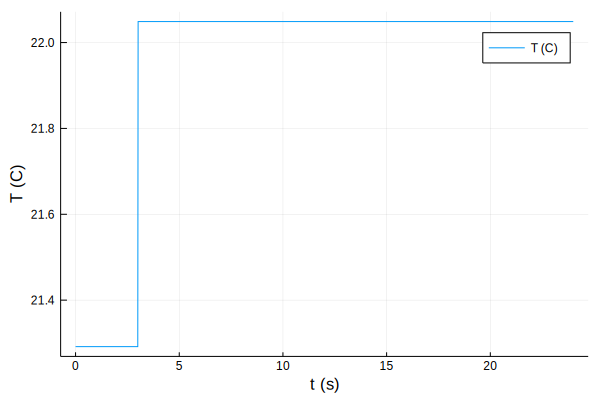

In [42]:
plot(t/3600, T_t-273.15*ones(size(T_t)),xlabel = "t (s)",ylabel = "T (C)",label="T (C)",ylim=0:100)
#plot!(t/3600,-psil_t/100000,xlabel = "t (s)",ylabel = "|psi_l (1000 hPa)|",label="psi_l",ylim=0:100)

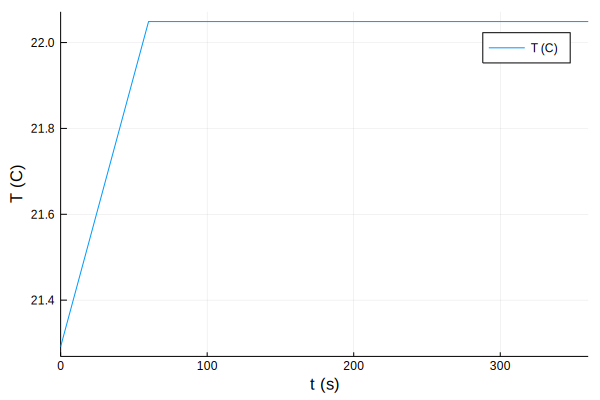

In [43]:
plot(t-3*3600*ones(size(t)), T_t-273.15*ones(size(T_t)),xlabel = "t (s)",ylabel = "T (C)",label="T (C)",xlims=(0*3600,0.1*3600))

In [44]:
savefig(joinpath(output_dir, "T_psi_t.png"))

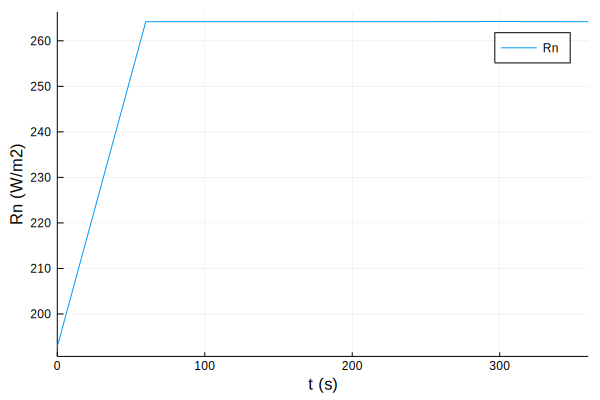

In [45]:
plot(t-3*3600*ones(size(t)),  Rn_t,xlabel = "t (s)",ylabel = "Rn (W/m2)",label="Rn",xlims=(0*3600,0.1*3600))

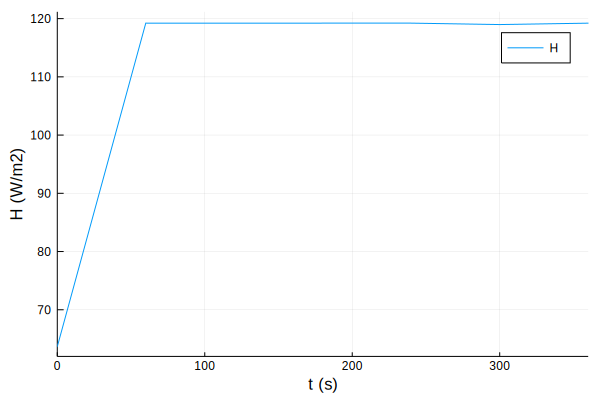

In [46]:
plot(t-3*3600*ones(size(t)), H_t,xlabel  = "t (s)",ylabel = "H (W/m2)" ,label="H",xlims=(0*3600,0.1*3600))

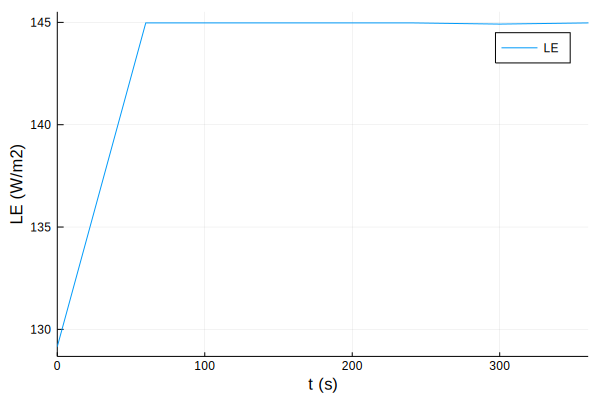

In [47]:
plot(t-3*3600*ones(size(t)), LE_t,xlabel = "t (s)",ylabel = "LE (W/m2)",label="LE",xlims=(0*3600,0.1*3600))

In [40]:
length(t)

1441

In [44]:
l.LMA

0.1f0